# MAE6292 - Homework \# 2

Camera Calibration and Object Rendering

## Import Modules



In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cv2

## imshow

It turns out that `cv2.imshow()` does not work in Jupter Notebook as well. You may use the follwing function `cv2_imshow` instead. 

In [2]:
def cv2_imshow(image):
    plt.figure(dpi=200)
    mode = len(np.shape(image))
    if mode==3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    elif mode==2:
        plt.imshow(image, cmap='gray')
    else:
        print('Unsuported image size')
        raise
    plt.xticks([]), plt.yticks([]) 
    plt.axis('off')

## Getting Checkerboard

Get a 6x4 checkerboard image at [checkerboards](https://raw.githubusercontent.com/MarkHedleyJones/markhedleyjones.github.io/master/media/calibration-checkerboard-collection/Checkerboard-A4-40mm-6x4.pdf
)

You have two options to generate your own photo image of the above checkerboard.

1. Print the above pdf file, and leave it on a flat surface. Take a photo with your phone or camera. Make it sure that **the upper, left square is black** in your photo. Otherwise, the detected corners will be arranged in the reverse order. 
2. If you don't have a printer, display it on your monitor and take a photo with your phone. (Clean your monitor, and increase brightness and contrast)

NOTE: take the photo at an angle (oblique or tilted view), rather than directly overhead. 
Copy the photo file into your homework folder. 

## Problem 1 (Detect Corners)

In this part, 

1. Detect the corners with `cv2.findChessboardCorneres()` (recall the size of the board is determined by the number of the inner corners)
2. Refine the corners with `cv2.cornerSubPix()`
3. Draw the refined corners with `cv2.drawChessboardCorners()`

Save your image with the detected corners as **`prob1.png`**


True

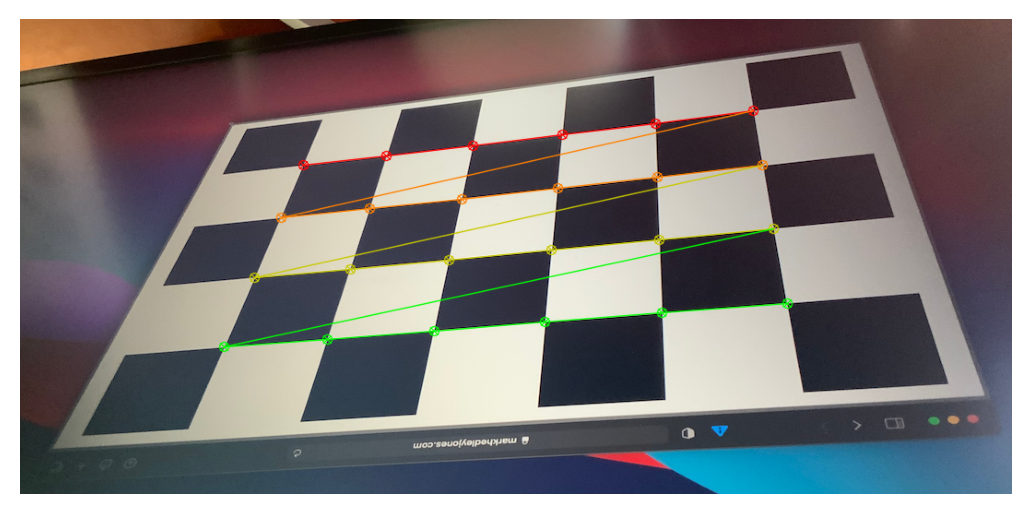

In [9]:
# load input image
raw_img = cv2.imread("IMG_0535.png")
if raw_img is None:
    raise RuntimeError("Image file not found or could not be opened")

# convert to grayscale 
gray_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)

# checkerboard inner-corner layout (columns, rows)
board_dims = (6, 4)

# detection config
detect_cfg = (
    cv2.CALIB_CB_ADAPTIVE_THRESH |
    cv2.CALIB_CB_NORMALIZE_IMAGE
)

# locate initial chessboard corners
found_board, corner_pts = cv2.findChessboardCorners(
    gray_img,
    board_dims,
    detect_cfg
)

if not found_board:
    raise ValueError("Checkerboard corners were not detected")

# termination criteria 
subpix_criteria = (
    cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
    30,
    1e-3
)

# refine corner locations
refined_pts = cv2.cornerSubPix(
    gray_img,
    corner_pts,
    winSize=(11, 11),
    zeroZone=(-1, -1),
    criteria=subpix_criteria
)

# visualize detected corners
viz_img = raw_img.copy()
cv2.drawChessboardCorners(
    viz_img,
    board_dims,
    refined_pts,
    found_board
)

cv2_imshow(viz_img)

# save
cv2.imwrite("prob1.png", viz_img)

## Problem 2 (Calibrate Camera)

1. Create an array `obj_points` for the 3D world coordinates of the corners detected above. It should follow the same order as the corners. You may set `CHECKER_WIDTH=1`, i.e., the unit-length in the world coordinates corresponds to the side of one square. 

   You can define any world frame. In class, we defined it such that the origin is at the upper-left inner corner; the x-axis points toward righit; the y-axis point toward down; and the z-axis points down into the board.


2. Calibrate camera with `cv2.calibrateCamera`
3. Print the calibration matrix `K`
4. Print the vector from the origin of the world frame to the origin of the camera frame, resolved in the world frame.

In [13]:
CHECKER_WIDTH = 1.0
cols, rows = (6,4)

# create 3D world coordinates of checkerboard corners
obj_points = np.zeros((rows * cols, 3), dtype=np.float32)

idx = 0
for y in range(rows):
    for x in range(cols):
        obj_points[idx] = [x * CHECKER_WIDTH, y * CHECKER_WIDTH, 0]
        idx += 1

# reshape for OpenCV 
object_points = [obj_points.reshape(-1, 1, 3)]
image_points = [corners_refined]

# calibrate camera
h, w = gray.shape[:2]

ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(
    object_points,
    image_points,
    (w, h),
    None,
    None
)

# print calibration matrix K
print("Calibration matrix K:")
print(K)

# camera origin in world coordinates
R, _ = cv2.Rodrigues(rvecs[0])
camera_origin_world = -R.T @ tvecs[0]

print("\nCamera origin in world frame:")
print(camera_origin_world)

Calibration matrix K:
[[1.04100217e+03 0.00000000e+00 5.08036579e+02]
 [0.00000000e+00 9.78425542e+02 3.06474310e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Camera origin in world frame:
[[ 4.4278656 ]
 [ 8.75141283]
 [-5.76917226]]


## Problem 3 (Draw a Cube)

Here we are going to draw a cube as illustrated below.
Note that the side of the cube is equal to the side of the checkerboard sequare, and the cube is at the white square in the middle.

![](img_cube.png)

1. Define a `4 x 8 np.array`, namely `vertices`, whose column corresponds to the homogeneous coordinates of each vertex of the above cube. Recall the point `(x,y,z)` becomes `(x,y,z,1)` in the homogeneous coordinate. For example, the first vertex on the bottom surface is at [2,1,0,1], and the second is at [3,1,0,1]
2. Define a list of [tuples](https://www.w3schools.com/python/python_tuples.asp), namely `edges` corresponding to 12 edges of the cube. For example, if the vertex 0 is connected to the vertex 1, the corresponding edge is defined by `edges = [ (0,1) ]`. As there are 12 edges, `edges` should contain 12 tuples. 
3. Use `cv2.line` to draw 12 edges, to complete the cube. You may choose any color, but the line width should be greater than or equal to `2`
4. Make it sure that the cube is at the white square in the middle. Save your image as `prob3.png`

True

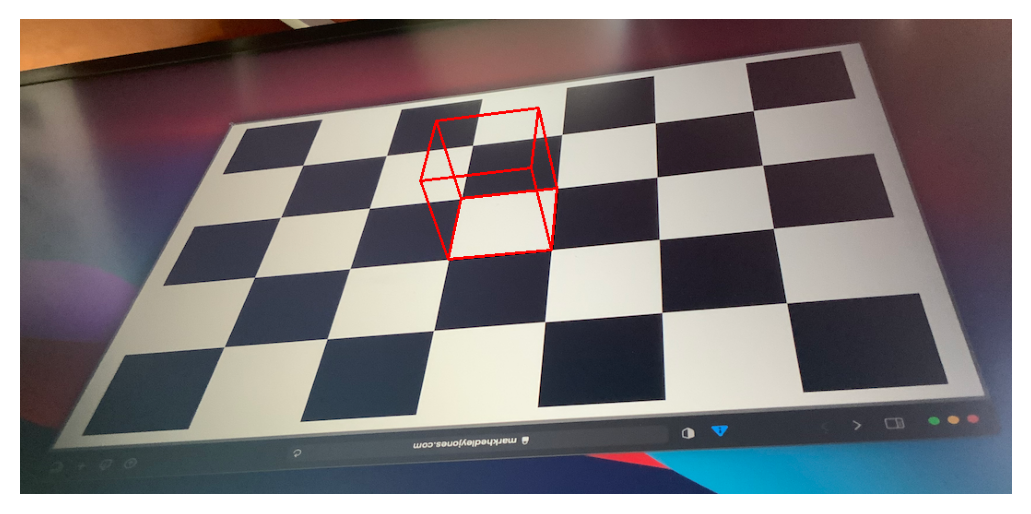

In [17]:
# cube side length
cube_size = CHECKER_WIDTH

# center cube on middle white square
cx = (CHECKER[0] - 1) / 2 - 0.5
cy = (CHECKER[1] - 1) / 2 - 0.5

# define cube vertices shape (4, 8)
vertices = np.array([
    [cx,       cy,       0,  1],
    [cx+1,     cy,       0,  1],
    [cx+1,     cy+1,     0,  1],
    [cx,       cy+1,     0,  1],
    [cx,       cy,      -1,  1],
    [cx+1,     cy,      -1,  1],
    [cx+1,     cy+1,    -1,  1],
    [cx,       cy+1,    -1,  1],
]).T  

# define cube edges (12 total)
edges = [
    (0,1), (1,2), (2,3), (3,0),
    (4,5), (5,6), (6,7), (7,4),
    (0,4), (1,5), (2,6), (3,7)
]

# project 3D points to image
cube_points_3d = vertices[:3].T.astype(np.float32)

img_points, _ = cv2.projectPoints(
    cube_points_3d,
    rvecs[0],
    tvecs[0],
    K,
    dist
)

img_points = img_points.reshape(-1, 2).astype(int)

# draw cube
img_cube = img.copy()

for i, j in edges:
    cv2.line(
        img_cube,
        tuple(img_points[i]),
        tuple(img_points[j]),
        (0, 0, 255),
        2
    )

cv2_imshow(img_cube)
cv2.imwrite("prob3.png", img_cube)

## How to Turn in

Make it sure you add the following three files to the repository before pusing it back to github.
1. Your image file
2. prob1.png
3. prob3.png